In [1]:
import os, random, sys, json, time
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from scipy.stats import pearsonr, spearmanr, wasserstein_distance, skew, kurtosis
from scipy.signal import find_peaks

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mutual_info_score
from sklearn.manifold import TSNE

from pymatgen.core.structure import Structure, Lattice
from pymatgen.io.ase import AseAtomsAdaptor

import warnings

In [2]:
warnings.filterwarnings("ignore", message="Issues encountered while parsing CIF")

#### Read data

In [3]:
#####################
# Read mbj dataset
#####################
with open('../datasets/mbj_avg_data.json', 'r') as f:
    data = json.load(f)
dff = pd.DataFrame(data)


#####################
# Convert CIF to pymatgen structures
#####################
def cif2pystructure(row):
    py_struc = Structure.from_str(row['cif'], fmt='cif')
    return py_struc

# Apply the function to create the 'pystructure' column
dff['pystructure'] = dff.apply(cif2pystructure, axis=1)


#####################
# Filter by number density
#####################
def filter_by_number_density(df):
    # Calculate number density for each row
    df['number_density'] = [df['pystructure'].iloc[i].num_sites / df['pystructure'].iloc[i].volume
                            for i in range(df.shape[0])]
    # Drop rows with 'number_density' < 0.005
    df_filtered = df[df['number_density'] >= 0.005]
    # Adjust the index numbering
    df_filtered.index = list(np.arange(0, df_filtered.shape[0]))
    return df_filtered

# Apply the function to dff
dff = filter_by_number_density(dff)


#####################
# Find the index of the closest value in energy_range to the band_gap
#####################
def find_closest_index(row):
    return np.abs(np.array(row['energy_range']) - np.array(row['band_gap'])).argmin()

# Apply the function to each row and create the 'band_gap_index' column
dff['band_gap_index'] = dff.apply(find_closest_index, axis=1)


#####################
# Set values to zero based on band_gap_index
#####################
def set_values_to_zero(row):
    band_gap_index = row['band_gap_index']
    imag_avg_interp = row['imag_avg_interp']

    # Set values with index <= band_gap_index to zero
    row['imag_avg_interp'] = np.where(np.arange(len(imag_avg_interp)) <= band_gap_index, 0, imag_avg_interp)
    return row

# Apply the function to each row
dff = dff.apply(set_values_to_zero, axis=1)


#####################
# Create a sub-DataFrame with selected columns
#####################
selected_columns = ['pystructure', 'band_gap', 'band_gap_index', 'energy_range', 
                    'real_avg_interp', 'imag_avg_interp']

df = dff[selected_columns]


#####################
# Count non-None values in each column
#####################
non_none_count = df.count()
print('count:', non_none_count)


#####################
# Normalize to average norm & probability distribution normalized spectrum
#####################
# Normalize 
def normalize_target(vector):
    n_vec = vector / np.sum(vector) 
    return n_vec.tolist()

# Calculate target norm (average value over the spectrum)
def target_norm(vector):
    norm = np.sum(vector) / len(vector)
    return norm 

df['imag_normalized_mean'] = df['imag_avg_interp'].apply(normalize_target)
df['imag_mean'] = df['imag_avg_interp'].apply(target_norm)


#####################
# Normalize to max & normalized spectrum between 0 and 1
#####################
# Normalize 
def normalize_target(vector):
    n_vec = vector / np.max(vector) 
    return n_vec.tolist()

# Calculate target norm (maximum value over the spectrum)
def target_norm(vector):
    norm = np.max(vector)
    return norm 

df['imag_normalized_max'] = df['imag_avg_interp'].apply(normalize_target)
df['imag_max'] = df['imag_avg_interp'].apply(target_norm)

/home/common/akram/miniconda3_py311/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:142: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


count: pystructure        14560
band_gap           14560
band_gap_index     14560
energy_range       14560
real_avg_interp    14560
imag_avg_interp    14560
dtype: int64


/tmp/ipykernel_267209/3903940608.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['imag_normalized_mean'] = df['imag_avg_interp'].apply(normalize_target)
/tmp/ipykernel_267209/3903940608.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['imag_mean'] = df['imag_avg_interp'].apply(target_norm)
/tmp/ipykernel_267209/3903940608.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

#### Extract more target properties from optical spectrum

In [4]:
# Function to calculate the energy at the maximum peak
def calculate_energy_for_max(spectrum):
    max_index = np.argmax(spectrum)
    energy_for_max = max_index * 0.04  # Multiply index by the grid resolution (12 eV / 300 = 0.04 eV) to get the energy
    return energy_for_max

# Apply the function to create a new column 'E_max'
df['E_max'] = df['imag_avg_interp'].apply(calculate_energy_for_max)

# Function to calculate the number of peaks in the spectrum
def calculate_n_peaks(spectrum):
    peaks, _ = find_peaks(spectrum, height=0.25*max(spectrum), distance=2.0/0.04)
    return len(peaks)

# Apply the function to create a new column 'n_peaks'
df['n_peaks'] = df['imag_avg_interp'].apply(calculate_n_peaks)

# Define the function to calculate mean, variance, skewness, and kurtosis of the PDF-normalized dielectric spectrum
def calculate_energy_stats(prop_dist):
    E_mean = np.sum(prop_dist * np.arange(0, 12, 0.04))  # Calculate mean
    E_var = np.sum(prop_dist * (np.arange(0, 12, 0.04) - E_mean) ** 2)  # Calculate variance
    E_skew = skew(prop_dist, axis=-1)  # Calculate skewness
    E_kurt = kurtosis(prop_dist, axis=-1)  # Calculate kurtosis
    
    return pd.Series({'E_mean': E_mean, 'E_var': E_var, 'E_skew': E_skew, 'E_kurt': E_kurt})

# 'df['imag_normalized_mean']' is a probability density function (PDF)
# Apply the function to create new columns 'E_mean', 'E_var', 'E_skew', and 'E_kurt'
df[['E_mean', 'E_var', 'E_skew', 'E_kurt']] = df['imag_normalized_mean'].apply(calculate_energy_stats).apply(pd.Series)

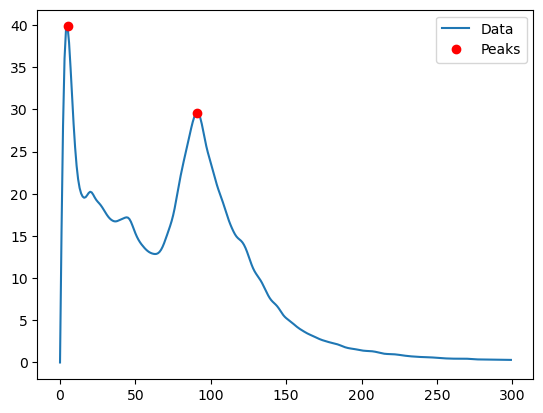

In [5]:
# Example on find_peaks function
j = 1042
# Find peaks in the data with specified height and distance thresholds
peaks, _ = find_peaks(df['imag_avg_interp'].iloc[j], 
                      height=0.25*max(df['imag_avg_interp'].iloc[j]), 
                      distance=2.0/0.04)

# Plot the data
plt.plot(df['imag_avg_interp'].iloc[j], label='Data')

# Plot the peaks with red dots
plt.plot(peaks, df['imag_avg_interp'].iloc[j][peaks], 'ro', label='Peaks')  # 'ro' for red dots at peaks

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()


### Read latent feature vectors

In [6]:
# Path of latent features (Obtained from the GNN models used learn the imaginary part of the dielectric function)
sf_latfeat_path = './latent_features/singlefidelity/' 
mf_latfeat_path = './latent_features/multifidelity/'

# Read latent features of the single-fidelity GNN models
latfeat_UnNorm_ = np.load(os.path.join(sf_latfeat_path, 'latfeat_sf_imag_mbj_UnNorm.npy'))
latfeat_MaxNorm_ = np.load(os.path.join(sf_latfeat_path, 'latfeat_sf_imag_mbj_MaxNorm.npy'))
latfeat_AvgNorm_ = np.load(os.path.join(sf_latfeat_path, 'latfeat_sf_imag_mbj_AvgNorm.npy'))

# Read latent features of the single-fidelity GNN models
latfeat_tl_ = np.load(os.path.join(mf_latfeat_path, 'latfeat_tl_imag_opt_AvgNorm.npy'))
latfeat_fe_ = np.load(os.path.join(mf_latfeat_path, 'latfeat_fe_imag_optmbj_AvgNorm.npy'))

# Get metals/nonmetals indices
zero_bg_indices = df[df['band_gap'] == 0].index.tolist()
nonzero_bg_indices = df[df['band_gap'] > 0].index.tolist()

# Define the targets properties (extracted from the dielectric spectrum) whose correlations would be 
# tested with respect to the latent features
targets1 = np.array(df['imag_normalized_max'].tolist())
targets2 = np.array(df['imag_normalized_mean'].tolist())
targets3 = np.array(df['imag_max'].tolist()).reshape(-1, 1)
targets4 = np.array(df['imag_mean'].tolist()).reshape(-1, 1)
targets5 = np.array(df['E_max'].tolist()).reshape(-1, 1)
targets6 = np.array(df['E_mean'].tolist()).reshape(-1, 1)
targets7 = np.array(df['E_var'].tolist()).reshape(-1, 1)
targets8 = np.array(df['E_skew'].tolist()).reshape(-1, 1)
targets9 = np.array(df['E_kurt'].tolist()).reshape(-1, 1)
targets10 = np.array(df['real_avg_interp'].tolist())[:,1].reshape(-1, 1)
targets11 = np.array(df['n_peaks'].tolist()).reshape(-1, 1)
targets12 = np.array(df['band_gap'].tolist()).reshape(-1, 1)

# Define targets' names
tar_names = ['Max-Normalized', 'Mean-Normalized', 
             'Max', 'Mean', 
             'E_max', 'E_mean', 'E_var', 'E_skew', 'E_kurt',
             'dielec_const',  
             'n_peaks', 'Band_gap']

### ------ ###

### ------ ###

### Analyze the importance of different spectrum target properties in organizing the latent feature space of materials

In [7]:
# Function to plot correlation between target and latent feature distances
def plot_correlation(typ, latfeat_to_analyze, targets, zero_bg_indices, nonzero_bg_indices, tar_names):
    plt.figure(figsize=(10, 6), dpi=100)
    plt.suptitle(f'Correlation between Target and Latfeat Distances ({typ.capitalize()})')

    for i, latfeat in enumerate([latfeat_to_analyze]):
        # Determine indices based on the material class
        if typ == 'metal':
            indices = zero_bg_indices
        elif typ == 'nonmetal':
            indices = nonzero_bg_indices

        # Extract latent features of the specified material class (metals or nonmetals)
        latfeat = latfeat[indices]

        # Compute the distance matrix for each of the targets
        tar_dist = [pairwise_distances(target[indices], metric=d, n_jobs=20) for target in targets]

        # Flatten the upper triangle of each distance matrix
        tar_dist = [dist[np.triu_indices(dist.shape[0], k=1)].flatten() for dist in tar_dist]

        # Use MinMaxScaler for normalization
        scaler = MinMaxScaler()
        tar_dist = [scaler.fit_transform(dist.reshape(-1, 1)).flatten() for dist in tar_dist]

        # Compute and flatten the latent feature distance matrix
        latfeat_dist = pairwise_distances(latfeat, metric=d, n_jobs=20)
        latfeat_dist = latfeat_dist[np.triu_indices(latfeat_dist.shape[0], k=1)].flatten()
        latfeat_dist = scaler.fit_transform(latfeat_dist.reshape(-1, 1)).flatten()

        # Calculate and print correlation coefficients
        correlation_coefficients_nm = [spearmanr(tar, latfeat_dist)[0] for tar in tar_dist]

        # Make bar plot side by side with separation and three colors
        for j, correlation_coefficient in enumerate(correlation_coefficients_nm):
            plt.bar(i + j, correlation_coefficient, label=tar_names[j], color=sequential_colors[j], 
                    edgecolor='black', linewidth=2)

    # Make frame and ticks thicker
    plt.gca().spines['top'].set_linewidth(2)
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)
    plt.gca().spines['right'].set_linewidth(2)
    plt.gca().xaxis.set_tick_params(width=2, size=8) 
    plt.gca().yaxis.set_tick_params(width=2, size=8)             

    plt.xticks(range(len(tar_names)), tar_names, rotation=45)
    plt.ylabel('Correlation Coefficient')
    plt.legend()
    plt.show()

    print(f'Correlation coefficients for {typ}:', correlation_coefficients_nm)

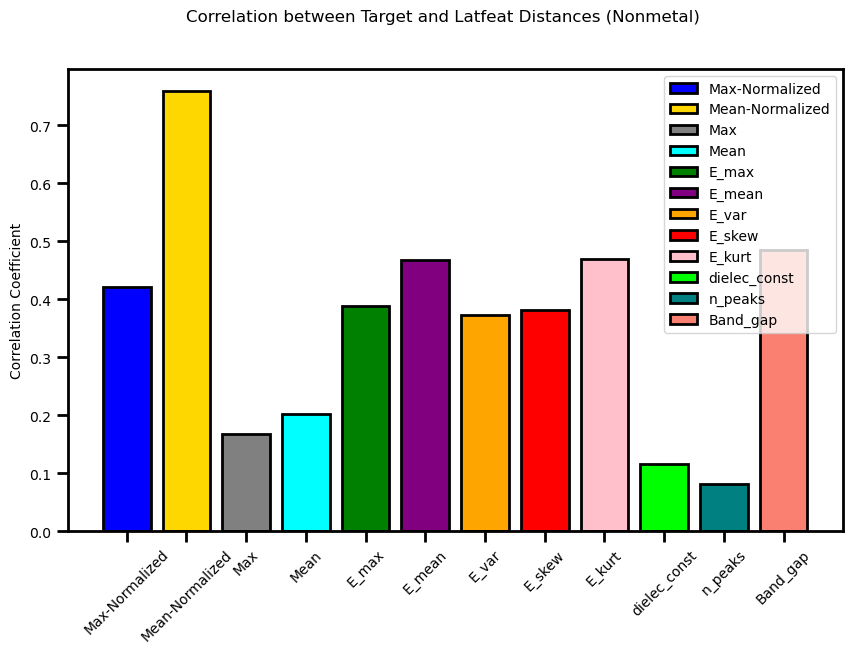

Correlation coefficients for nonmetal: [0.42033798116874205, 0.758773780505205, 0.16760682934397275, 0.20186476305866183, 0.38727728558176616, 0.46751223173965767, 0.3731634259186624, 0.3818144654822283, 0.46912041278963196, 0.11599858893700705, 0.08058902576896552, 0.4839692369670881]


/tmp/ipykernel_267209/3533238176.py:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation_coefficients_nm = [spearmanr(tar, latfeat_dist)[0] for tar in tar_dist]


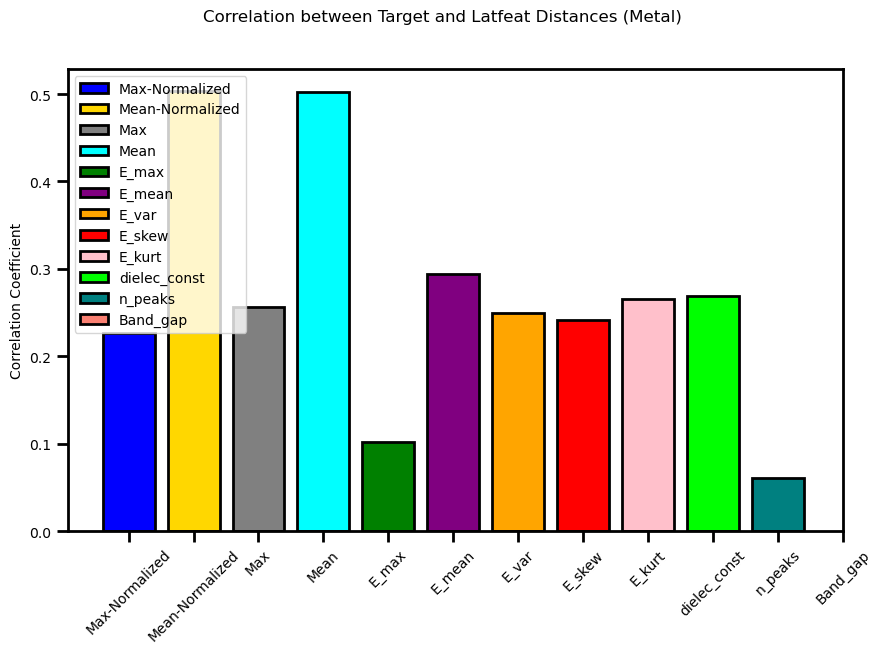

Correlation coefficients for metal: [0.22635729485676914, 0.5034477722877467, 0.2564450232695019, 0.5022105952844569, 0.10189536486009736, 0.294548910689377, 0.24930580832819477, 0.24202283827254634, 0.2660587318280853, 0.2686681384455119, 0.06028161332165508, nan]


In [8]:
# Specify distance type
d = 'euclidean'

# Specify what latent features (i.e., from which GNN model) to consider
# Let's choose the latent features obtained from the fidelity-embedding AvgNorm model (latfeat_fe_)
latfeat_to_analyze = latfeat_fe_


# Define the list of target properties
targets = [targets1, targets2, targets3, targets4, targets5, targets6, 
           targets7, targets8, targets9, targets10, targets11, targets12]

# Define a list of sequential colors with 12 elements for the 12 targets defined above
sequential_colors = ['blue', 'gold', 'grey', 'cyan', 'green', 'purple', 
                     'orange', 'red', 'pink', 'lime', 'teal', 'salmon']


# Plot for nonmetals
plot_correlation('nonmetal', latfeat_to_analyze, targets, zero_bg_indices, nonzero_bg_indices, tar_names)

# Plot for metals
plot_correlation('metal', latfeat_to_analyze, targets, zero_bg_indices, nonzero_bg_indices, tar_names)

####

### ------ ###

### ------ ###

#### Visualize the latent feature space using t-sne plots

In [11]:
# Plot tsne
def tsne_and_plot(latfeat_to_analyze, target_to_analyze, perplexity=150, random_state=42, tmin=-np.inf, tmax=np.inf):
    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    latent_tsne = tsne.fit_transform(latfeat_to_analyze)
    
    # Set up the plot
    plt.figure(figsize=(10, 8), dpi=200)
    
    # Filter data based on target range
    latent_tsne_filtered = np.array([latent_tsne[i] for i in range(len(latent_tsne)) if tmin < target_to_analyze[i] < tmax])
    target_filtered = np.array([target_to_analyze[i] for i in range(len(target_to_analyze)) if tmin < target_to_analyze[i] < tmax])
    
    # Create a scatter plot with color-coded targets and 'hot' colormap
    scatter = plt.scatter(latent_tsne_filtered[:, 0], latent_tsne_filtered[:, 1], c=target_filtered, cmap='hot', s=40)
    
    # Add colorbar with white tick labels
    colorbar = plt.colorbar(scatter)
    colorbar.ax.tick_params(axis='y', width=2, size=8)
    colorbar.outline.set_linewidth(2)
    
    # Adjust layout and save the figure
    plt.gca().spines['top'].set_linewidth(2)
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)
    plt.gca().spines['right'].set_linewidth(2)
    plt.gca().xaxis.set_tick_params(width=2, size=8) 
    plt.gca().yaxis.set_tick_params(width=2, size=8) 
    
    
    # Set x and y axis ticks every 60 steps
    plt.gca().xaxis.set_major_locator(MultipleLocator(60))
    plt.gca().yaxis.set_major_locator(MultipleLocator(60))
    
    plt.show()

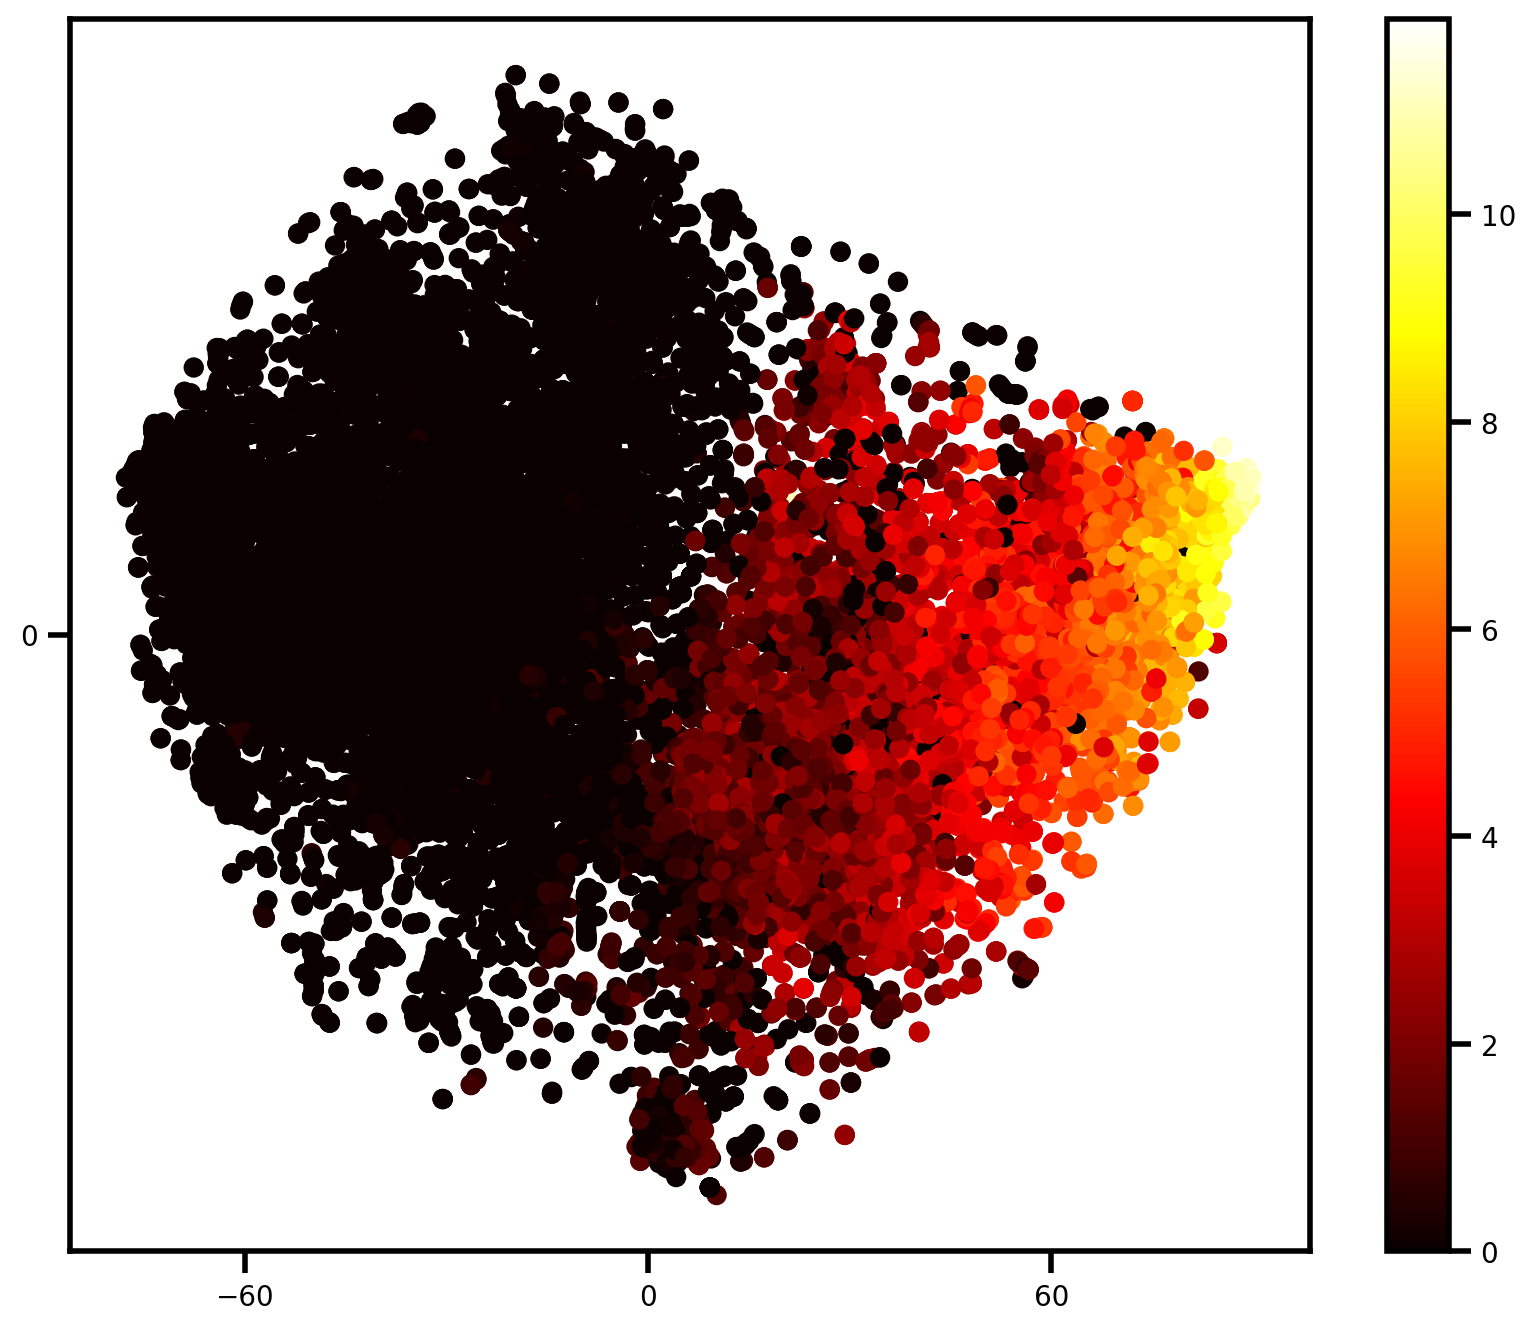

In [12]:
# Specify what latent features (i.e., from which GNN model) to consider
# Let's choose the latent features obtained from the fidelity-embedding AvgNorm model (latfeat_fe_)
latfeat_to_analyze = latfeat_fe_

# Specify a scalar target property from the spectrum to analyze as color map 
target_to_analyze = targets12 # (band gap)

# Plot
tsne_and_plot(latfeat_to_analyze, target_to_analyze, tmin=-np.inf, tmax=np.inf)